[View in Colaboratory](https://colab.research.google.com/github/prasad4fun/NLP/blob/master/NER_LSTM_CRF.ipynb)

In [0]:
import pandas as pd
import numpy as np

In [0]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [0]:
data = data.fillna(method="ffill")

In [5]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [6]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

35179

In [7]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

In [0]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [0]:
getter = SentenceGetter(data)

In [0]:
sent = getter.get_next()

In [11]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [0]:
sentences = getter.sentences

In [0]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [14]:
word2idx["Obama"]

1334

In [15]:
tag2idx["B-geo"]

4

In [16]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

Using TensorFlow backend.


In [0]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

In [0]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [0]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [0]:
from keras.utils import to_categorical

In [0]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [26]:
! pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-qwb017w2
  Running setup.py bdist_wheel for keras-contrib ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-3r_b6orm/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

In [0]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

In [0]:
model = Model(input, out)

In [0]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            703600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 17)            1190      
Total params: 738,240
Trainable params: 738,240
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 855s 22ms/step - loss: 0.1114 - acc: 0.9710 - val_loss: 0.0439 - val_acc: 0.9845
Epoch 2/5
38846/38846 [==============================] - 817s 21ms/step - loss: 0.0323 - acc: 0.9882 - val_loss: 0.0281 - val_acc: 0.9889
Epoch 3/5
38846/38846 [==============================] - 818s 21ms/step - loss: 0.0238 - acc: 0.9905 - val_loss: 0.0249 - val_acc: 0.9897
Epoch 4/5
38846/38846 [==============================] - 817s 21ms/step - loss: 0.0208 - acc: 0.9914 - val_loss: 0.0231 - val_acc: 0.9901
Epoch 5/5
38846/38846 [==============================] - 853s 22ms/step - loss: 0.0191 - acc: 0.9919 - val_loss: 0.0228 - val_acc: 0.9900


In [0]:
hist = pd.DataFrame(history.history)

In [34]:
hist

,acc,loss,val_acc,val_loss
0,0.971029,0.111403,0.984517,0.043864
1,0.988166,0.032271,0.988894,0.028064
2,0.990521,0.023796,0.989718,0.024924
3,0.991406,0.020766,0.990089,0.023149
4,0.991897,0.019075,0.990042,0.022763


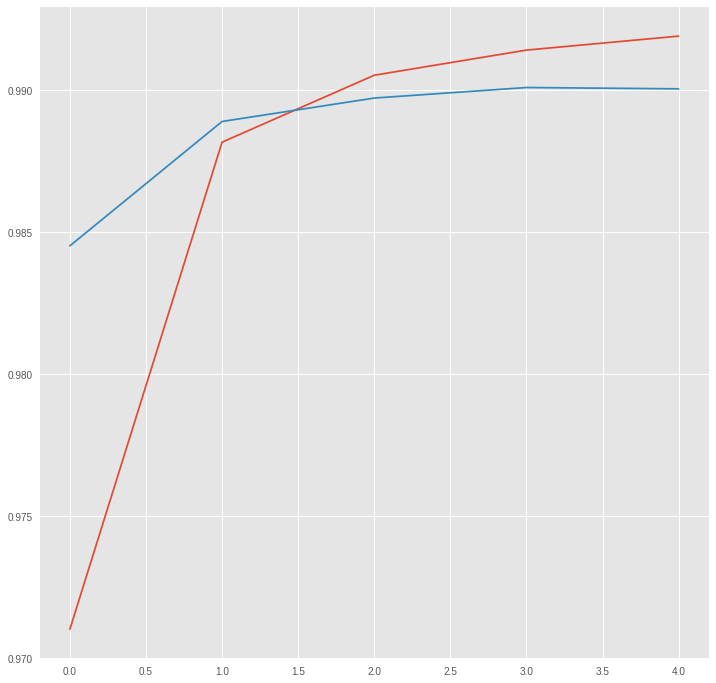

In [35]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [38]:
! pip install seqeval

In [0]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report


In [40]:
test_pred = model.predict(X_te, verbose=1)

4796/4796 [==============================] - 35s 7ms/step


In [0]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

In [42]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 82.3%


In [43]:
print(classification_report(test_labels, pred_labels))

             precision    recall  f1-score   support

        tim       0.86      0.84      0.85      2057
        org       0.72      0.66      0.69      1997
        gpe       0.97      0.92      0.95      1532
        per       0.78      0.78      0.78      1755
        geo       0.86      0.86      0.86      3814
        eve       0.00      0.00      0.00        38
        art       0.00      0.00      0.00        52
        nat       0.00      0.00      0.00        19

avg / total       0.83      0.81      0.82     11264



In [0]:
test_sentence = ["Hawking", "was", "a", "Fellow", "of", "the", "Royal", "Society", ",", "a", "lifetime", "member",
                 "of", "the", "Pontifical", "Academy", "of", "Sciences", ",", "and", "a", "recipient", "of",
                 "the", "Presidential", "Medal", "of", "Freedom", ",", "the", "highest", "civilian", "award",
                 "in", "the", "United", "States", "."]

In [0]:
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=max_len)

In [46]:
x_test_sent

array([[    0, 30339, 20566,  1653, 35097, 21687, 11213, 21209, 22923,
        20566, 25676,  2323, 35097, 21687, 16390, 17735, 35097, 32820,
        22923,    40, 20566, 30561, 35097, 21687, 25490,     0, 35097,
        23694, 22923, 21687,  8832, 28741, 24986, 17586, 21687, 12880,
        15566,  8296,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]], dtype=int32)

In [47]:
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(test_sentence, p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))

Word           ||Prediction
Hawking        : I-nat
was            : O    
a              : O    
Fellow         : O    
of             : O    
the            : O    
Royal          : B-org
Society        : I-org
,              : O    
a              : O    
lifetime       : O    
member         : O    
of             : O    
the            : O    
Pontifical     : B-org
Academy        : I-org
of             : I-org
Sciences       : I-org
,              : O    
and            : O    
a              : O    
recipient      : O    
of             : O    
the            : O    
Presidential   : O    
Medal          : I-nat
of             : O    
Freedom        : B-org
,              : O    
the            : O    
highest        : O    
civilian       : O    
award          : O    
in             : O    
the            : O    
United         : B-geo
States         : I-geo
.              : O    
